In [3]:
import pickle
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats as stats

import figures

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Acknowledgement

Thanks to [J. Walton's post](https://jwalton.info/Embed-Publication-Matplotlib-Latex/)---instructions for pdf-perfect plots from matplotlib.

Thanks to Sihan for writing the code to plot the IGT data.

## Load the data

In [4]:
def load(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

stability_data = load('data/stability-data.pkl')
igt_data       = load('data/igt-data.pkl')
xigt_data      = load('data/xigt-data.pkl')

### Set the style and layout

In [5]:
TEXT_WIDTH_PT = 247.94499
EXTRA_INCHES  = 0.5

def subplots(rows, cols,
             titles=True, transpose_titles=False, x=0.12, y=0.65,
             adjust=True, wspace=0.06, hspace=0.12,
             **kwargs):
    pt = TEXT_WIDTH_PT + figures.inches_to_pt(EXTRA_INCHES)
    fig, axes = figures.subplots(rows, cols, pt, **kwargs)
    if titles:
        figures.title_subplots(axes.T if transpose_titles else axes, x=x, y=y)
    if adjust:
        plt.subplots_adjust(hspace=hspace, wspace=wspace)
    return fig, axes

In [6]:
c = plt.cm.plasma
GRAY   = "gray"
PURPLE = c(0.0)
ORANGE = c(0.65)
print("purple", PURPLE)
print("orange", ORANGE)

figures.use_tex_params()

purple (0.050383, 0.029803, 0.527975, 1.0)
orange (0.918109, 0.453603, 0.339529, 1.0)


Creating 4 by 2 subplots, (3.930814860938149, 4.858754375085935) inches.


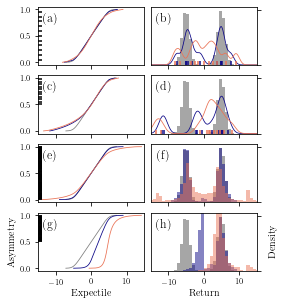

In [20]:
fig, axes = subplots(4, 2, sharex='col', sharey='col', wspace=0.06, hspace=0.18)

all_samples = np.concatenate(
    [stability_data[k][t]['sample']
         for k in ['opt-based imputer', 'opt-based imputer (half)',
                   'direct imputer',    'direct imputer (half)'   ]
         for t in [0, 50]
    ]
)

s_range = all_samples.min(), all_samples.max()
support = np.linspace(*s_range, 500)
bins =  np.linspace(*s_range, 50)

for i, k in enumerate(['opt-based imputer', 'opt-based imputer (half)',
                       'direct imputer',    'direct imputer (half)'   ]):
    log = stability_data[k]
    # expectiles
    axes[i, 0].plot(*log[0]['minor_expectiles'], color="gray", linewidth=0.8)
    taus = log[0]['major_expectiles'][1]
    axes[i, 0].scatter(np.full_like(taus, -14.3), taus,
                       marker="_", color="black", zorder=10, s=15)
    # samples
    axes[i, 1].yaxis.set_label_position("right")
    axes[i, 1].yaxis.tick_right()
    axes[i, 1].hist(log[0]['sample'], density=True, bins=bins, alpha=0.7, color="gray")
    for t, color in [(1, PURPLE), (50, ORANGE)]:
        axes[i, 0].plot(*log[t]['minor_expectiles'], color=color, linewidth=0.8)
        if i < 2:
            kd = stats.gaussian_kde(log[t]['sample'], bw_method=0.18)
            axes[i, 1].plot(support, kd.pdf(support), color=color, linewidth=0.8)
            axes[i, 1].scatter(log[t]['sample'], np.full_like(log[1]['sample'], 0.006),
                               marker="|", color=color, zorder=10, s=10)
        else:
            axes[i, 1].hist(log[t]['sample'], density=True, bins=bins, alpha=0.5,
                           color=color)

axes[i, 0].set_xlim([-15, 15])
axes[i, 0].set_yticks([0, 0.5, 1])
axes[i, 0].set_ylabel("Asymmetry")
axes[i, 0].set_xlabel("Expectile")

axes[i, 1].set_ylim([0, 0.2])
axes[i, 1].set_xlim([-15, 15])
axes[i, 1].set_yticks([0, 0.19])
axes[i, 1].set_yticklabels([])
axes[i, 1].set_ylabel("Density")
axes[i, 1].set_xlabel("Return")

plt.savefig('plots/stability.pdf', bbox_inches='tight')
plt.show()

### Plot the igt data

Creating 3 by 2 subplots, (3.930814860938149, 3.6440657813144512) inches.


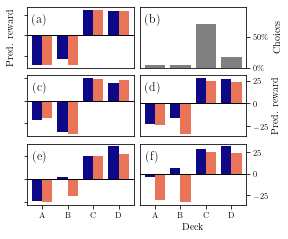

In [21]:
def plot_multi_bars(axis, heights, colors):
    N, K = heights.shape
    # make plots
    # prepare offsets
    xs = np.arange(0, N)
    os,h = np.linspace(-.4, .4, K, endpoint=False, retstep=True)
    os += h/2
    # add bars
    for i, hs in enumerate(heights):
        axis.bar(xs[i] + os, hs, h, color=colors)
    axis.axhline(linewidth=1, color='black')

def transform(data):
    return np.array([
        [data['A1'], data['A2']],
        [data['B1'], data['B2']],
        [data['C1'], data['C2']],
        [data['D1'], data['D2']],
    ])

fig, axes = subplots(3, 2, sharey=False)

for ax in axes[:, -1]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
for ax in axes[:, 0]:
    ax.set_yticklabels([])
for ax in axes[:-1, :].flat:
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which=u'both',length=0)
axes[0, 0].set_ylabel("Pred. reward")
axes[0, 1].set_ylabel("Choices")
axes[1, 1].set_ylabel("Pred. reward")
axes[2, 0].set_xticks([0, 1, 2, 3])
axes[2, 0].set_xticklabels(['A', 'B', 'C', 'D'])
axes[2, 1].set_xticks([0, 1, 2, 3])
axes[2, 1].set_xticklabels(['A', 'B', 'C', 'D'])
axes[2, 1].set_xlabel("Deck")

# plot the action counts
axes[0, 1].set_ylim(0, 0.99)
axes[0, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[0, 1].set_yticks([0, 0.5])
counts = np.atleast_2d(igt_data['traditional action counts'])
counts = (counts / counts.sum()).T
plot_multi_bars(axes[0, 1], counts, GRAY)

# plot the state values
plot_multi_bars(axes[0, 0], transform(igt_data['traditional']),      [PURPLE, ORANGE])
plot_multi_bars(axes[1, 0], transform(igt_data['opt-based']),        [PURPLE, ORANGE])
plot_multi_bars(axes[1, 1], transform(igt_data['opt-based (half)']), [PURPLE, ORANGE])
plot_multi_bars(axes[2, 0], transform(igt_data['direct']),           [PURPLE, ORANGE])
plot_multi_bars(axes[2, 1], transform(igt_data['direct (half)']),    [PURPLE, ORANGE])

plt.savefig('plots/igt.pdf', bbox_inches='tight')
plt.show()

Creating 2 by 2 subplots, (3.930814860938149, 2.4293771875429675) inches.


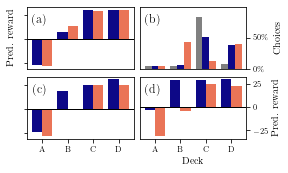

In [22]:
fig, axes = subplots(2, 2, sharey=False)

# for all plot on the right, tick right
for ax in axes[:, -1]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
for ax in axes[:, 0]:
    ax.set_yticklabels([])
for ax in axes[:-1, :].flat:
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which=u'both',length=0)
axes[0, 0].set_ylabel("Pred. reward")
axes[0, 1].set_ylabel("Choices")
axes[1, 1].set_ylabel("Pred. reward")
axes[1, 0].set_xticks([0, 1, 2, 3])
axes[1, 0].set_xticklabels(['A', 'B', 'C', 'D'])
axes[1, 1].set_xticks([0, 1, 2, 3])
axes[1, 1].set_xticklabels(['A', 'B', 'C', 'D'])
axes[1, 1].set_xlabel("Deck")

# plot the action counts

axes[0, 1].set_ylim(0, 0.99)
axes[0, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[0, 1].set_yticks([0, 0.5])
counts = np.stack([xigt_data['traditional action counts'],
                     xigt_data['direct action counts'],
                     xigt_data['direct (half) action counts']])
counts = (counts / counts.sum(axis=1, keepdims=True)).T
plot_multi_bars(axes[0, 1], counts, ['gray', c(0), c(0.65)])

# plot the state values
plot_multi_bars(axes[0, 0], transform(xigt_data['traditional']),   [PURPLE, ORANGE])
plot_multi_bars(axes[1, 0], transform(xigt_data['direct']),        [PURPLE, ORANGE])
plot_multi_bars(axes[1, 1], transform(xigt_data['direct (half)']), [PURPLE, ORANGE])

plt.savefig('plots/xigt.pdf', bbox_inches='tight')
plt.show()

In [23]:
# TODO: Online expectiles and learning rate stability

Creating 1 by 1 subplots, (3.930814860938149, 2.4293771875429675) inches.


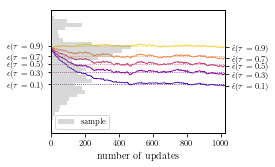

Creating 1 by 1 subplots, (3.930814860938149, 2.4293771875429675) inches.


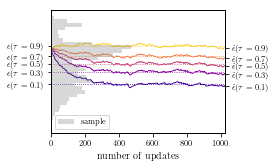

In [48]:
from util.expectiles import expectile, tauspace
from util.gmm import EXAMPLE

def learn_expectiles(sample, taus, base_learn_rate=0.02, scheme="mean",
                     cm=plt.cm.plasma, plot=True, filename=None):
    taus = np.asarray(taus)
    true_expts = expectile(sample, taus)
    
    # configure learning rates
    if scheme == "mean":
        neg_learn_rates = base_learn_rate * (1-taus)
        pos_learn_rates = base_learn_rate * taus
    elif scheme == "geo":
        neg_learn_rates = base_learn_rate * 0.5 * np.sqrt((1-taus)/taus)
        pos_learn_rates = base_learn_rate * 0.5 * np.sqrt(taus/(1-taus))
    elif scheme == "simple":
        neg_learn_rates = base_learn_rate * np.ones_like(taus)
        pos_learn_rates = base_learn_rate * taus/(1-taus)

    # learn
    pred_expts = np.zeros((sample.size+1, taus.size))
    for i, x in enumerate(sample, 1):
        pred_errors = x - pred_expts[i-1]
        # use negative update rate, except where error was positive
        learn_rates = np.where(pred_errors > 0, pos_learn_rates, neg_learn_rates)
        # with these rates, perform the update
        pred_expts[i] = pred_expts[i-1] + learn_rates * pred_errors

    # plot
    fig, (ax1) = subplots(1, 1, titles=False, adjust=False)
    ax2 = ax1.twinx()
    ax3 = ax1.twiny()
    ax3.hist(sample, color="gray", bins=30, density=True, alpha=0.3,
             orientation='horizontal', histtype='stepfilled',
             label="sample")
    ax3.legend(loc="lower left")
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_xlim([0, 0.2])
    for tau, true_eps, pred_epss in reversed(list(zip(taus, true_expts, pred_expts.T))):
        color = cm(tau)
        ax1.axhline(true_eps, color=color, linestyle=":", linewidth=0.8)
        ax2.plot(pred_epss, color=color,   linestyle="-", linewidth=0.8)
    ax1.set_xlim([0, sample.size])
    ax1.set_xlabel("number of updates")
    ax2.set_ylim(ax1.get_ylim())
    ax1.set_yticks(true_expts)
    ax1.set_yticklabels([f"$\\epsilon(\\tau={t:.1f})$" for t in taus])
    ax2.set_yticks(pred_expts[-1])
    ax2.set_yticklabels([f"$\\hat\\epsilon(\\tau={t:.1f})$" for t in taus])

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
sample = EXAMPLE(1024, plot=False)
learn_expectiles(sample, tauspace(5), scheme="mean", filename="plots/lrs-mean5.pdf")
learn_expectiles(sample, tauspace(5), scheme="geo",  filename="plots/lrs-geo5.pdf")

Creating 1 by 1 subplots, (3.930814860938149, 2.4293771875429675) inches.


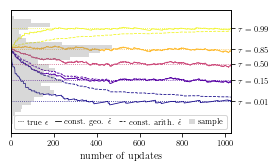

In [35]:
from util.expectiles import expectile, tauspace
from util.gmm import EXAMPLE

def learn_expectiles(sample, taus, base_learn_rate=0.02, scheme="mean"):
    taus = np.asarray(taus)

    # configure learning rates
    if scheme == "mean":
        neg_learn_rates = base_learn_rate * (1-taus)
        pos_learn_rates = base_learn_rate * taus
    elif scheme == "geo":
        neg_learn_rates = base_learn_rate * 0.5 * np.sqrt((1-taus)/taus)
        pos_learn_rates = base_learn_rate * 0.5 * np.sqrt(taus/(1-taus))
    elif scheme == "simple":
        neg_learn_rates = base_learn_rate * np.ones_like(taus)
        pos_learn_rates = base_learn_rate * taus/(1-taus)

    # learn
    pred_expts = np.zeros((sample.size+1, taus.size))
    for i, x in enumerate(sample, 1):
        pred_errors = x - pred_expts[i-1]
        # use negative update rate, except where error was positive
        learn_rates = np.where(pred_errors > 0, pos_learn_rates, neg_learn_rates)
        # with these rates, perform the update
        pred_expts[i] = pred_expts[i-1] + learn_rates * pred_errors

    return pred_expts

sample = EXAMPLE(1024, plot=False)
taus = np.array([0.01, 0.15, 0.5, 0.85, 0.99])
true_expts = expectile(sample, taus)
pred_expts_geo = learn_expectiles(sample, taus, scheme="geo")
pred_expts_ari = learn_expectiles(sample, taus, scheme="mean")

    
# plot
cm=plt.cm.plasma
fig, ax1 = subplots(1, 1, titles=False, adjust=False)
ax3 = ax1.twiny()
ax3.hist(sample, color="gray", bins=30, density=True, alpha=0.3,
         orientation='horizontal', histtype='stepfilled',
         label="sample")
ax3.plot([], color="black", linestyle=":",  linewidth=0.8, label="true $\\epsilon$")
ax3.plot([], color="black", linestyle="-",  linewidth=0.8, label="const. geo. $\\hat\\epsilon$")
ax3.plot([], color="black", linestyle="--", linewidth=0.8, label="const. arith. $\\hat\\epsilon$")
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlim([0, 0.2])
for tau, true_eps, pred_epss_geo, pred_epss_ari in \
        reversed(list(zip(taus, true_expts, pred_expts_geo.T, pred_expts_ari.T))):
    color = cm(tau)
    ax1.plot(pred_epss_geo, color=color, linestyle="-", linewidth=0.8)
    ax1.plot(pred_epss_ari, color=color, linestyle="--", linewidth=0.8)
    ax1.axhline(true_eps, color=color,   linestyle=":", linewidth=0.8)

ax1.set_xlim([0, sample.size])
ax1.set_xlabel("number of updates")
ax1.set_ylim(ax1.get_ylim())
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_yticks(true_expts)
ax1.set_yticklabels([f"$\\tau={t:.2f}$" for t in taus])

ax3.legend(loc="lower center", ncol=4,
           columnspacing=0.8, handletextpad=0.4,
          handlelength=0.8)

plt.tight_layout()
plt.savefig("plots/lrs-both.pdf", bbox_inches='tight')
plt.show()

Creating 1 by 1 subplots, (3.930814860938149, 2.4293771875429675) inches.


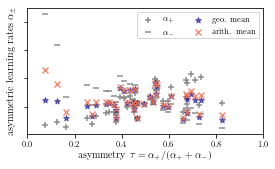

In [64]:
# # code from deepmind notebook:
# # #
# fig5 = scipy.io.loadmat("Figure5.mat")
# zero_crossings = fig5['zeroCrossings'][:, 0]
# neg_scale, pos_scale = np.zeros(40), np.zeros(40)
# for cell in range(zero_crossings.shape[0]):
#     neg_scale[cell] = fig5['scaleFactNeg'][cell, 0]
#     pos_scale[cell] = fig5['scaleFactPos'][cell, 0]
# # #
# hard-coding data:
empirical_aneg = np.array(
    [ 1.09973087, 1.09434475, 0.81754647, 1.75496968, 1.67606203
    , 1.31782321, 4.2774962 , 2.07487821, 1.20795529, 1.79866939
    , 1.5543464 , 1.53714398, 1.75414581, 0.99157462, 1.25610374
    , 1.64890165, 1.11847172, 1.33288318, 1.06756076, 0.13837144
    , 3.18862819, 0.40993265, 1.57898859, 1.25206699, 0.7408865 
    , 1.37378935, 0.64970639, 0.5290385 , 1.15801591, 0.88804109
    , 0.39178265, 0.78761288, 0.9504729 , 0.78957621, 1.8922945 
    , 1.27743886, 0.89029917, 1.35846128, 0.24108255, 0.94215354
    ])
empirical_apos = np.array(
    [ 1.24414574, 1.69343895, 1.19657156, 1.48369474, 1.9833994 
    , 1.58354132, 0.35294234, 1.33308177, 1.05604004, 1.37478407
    , 0.78240602, 0.81737661, 0.59848422, 0.82444628, 1.01318986
    , 0.68250221, 1.0999396 , 0.98199883, 0.40079706,     np.nan # no pos. responses
    , 0.4510079 , 0.79450089, 1.92060389, 1.01949126, 2.06489026
    , 0.79670455, 0.56191573, 1.10647801, 0.69592584, 1.85254849
    , 1.05660636, 1.94111345, 2.16614124, 0.47228333, 1.30471873
    , 1.37844464, 1.20718559, 0.26307763, 1.13978478, 1.92823193
    ])


# The experiment reveals the following:
empirical_taus = empirical_apos / (empirical_apos + empirical_aneg)
empirical_geom = (empirical_apos * empirical_aneg) ** 0.5
empirical_arim = (empirical_apos + empirical_aneg) *  0.5

# let's see what happens!
fig, ax = subplots(1, 1, titles=False, adjust=False)

ax.scatter(empirical_taus, empirical_apos, marker="+", color=GRAY,   alpha=0.9, label="$\\alpha_+$")
ax.scatter(empirical_taus, empirical_aneg, marker="_", color=GRAY,   alpha=0.9, label="$\\alpha_-$")
ax.scatter(empirical_taus, empirical_geom, marker="*", color=PURPLE, alpha=0.6, label="geo. mean")
ax.scatter(empirical_taus, empirical_arim, marker="x", color=ORANGE, alpha=0.8, label="arith. mean")

ax.set_xlim([0, 1])
ax.set_xlabel(r"asymmetry $\tau = \alpha_+ / (\alpha_+ + \alpha_-)$")
ax.set_yticklabels([])
ax.set_ylabel(r"asymmetric learning rates $\alpha_\pm$")
ax.legend(ncol=2)

plt.tight_layout()
plt.savefig("plots/lrs-mice.pdf", bbox_inches='tight')
plt.show()